# Self-supervised and multi-modal representation Learning: Notebook 3

Here we will align the image and light curve representations with contrastive learning, using CLIP (https://openai.com/research/clip). 

- From https://openai.com/research/clip.

## Aligning light curves and galaxy images in a common embedding space

In [36]:
import os, sys

import numpy as np
import pandas as pd
import math
from typing import Dict, Optional
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from einops import rearrange

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.transforms import RandomRotation
from torch.utils.data import TensorDataset, DataLoader, random_split
from src.models_multimodal import ConvMixer, TransformerWithTimeEmbeddings
from src.utils import get_valid_dir, LossTrackingCallback, plot_loss_history,get_embs
from src.dataloader import load_images, load_lightcurves, plot_lightcurve_and_images
from src.loss import sigmoid_loss, clip_loss
from typing import Tuple

from IPython.display import Image as IPImage

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data preprocessing

Load host images and inspect shape.

In [2]:
# ### Data preprocessing

data_dirs = ["ZTFBTS/", "/ocean/projects/phy230064p/shared/ZTFBTS/"]

# Get the first valid directory
data_dir = get_valid_dir(data_dirs)

# Load images from data_dir
host_imgs = load_images(data_dir)

# Load light curves from data_dir
time_ary, mag_ary, magerr_ary, mask_ary, nband = load_lightcurves(data_dir)


Loading images...


100%|██████████| 5171/5171 [00:21<00:00, 236.84it/s]


Loading light curves...


100%|██████████| 5170/5170 [00:14<00:00, 369.14it/s]


### Create dataset

In [21]:
# Time and mag tensors
time = torch.from_numpy(time_ary).float()
mag = torch.from_numpy(mag_ary).float()
mask = torch.from_numpy(mask_ary).bool()
magerr = torch.from_numpy(magerr_ary).float()

In [23]:


val_fraction = 0.05
batch_size = 64
n_samples_val = int(val_fraction * mag.shape[0])

dataset = TensorDataset(host_imgs, mag, time, mask, magerr)  # Include magerr in the dataset


dataset_train, dataset_val = random_split(dataset, [mag.shape[0] - n_samples_val, n_samples_val])
train_loader_no_aug = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader_no_aug = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

# Custom data loader with noise augmentation using magerr
class NoisyDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, noise_level_img, noise_level_mag, shuffle=True, **kwargs):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, **kwargs)
        self.max_noise_intensity = noise_level_img
        self.noise_level_mag = noise_level_mag

    def __iter__(self):
        for batch in super().__iter__():
            # Add random noise to images and time-magnitude tensors
            host_imgs, mag, time, mask, magerr = batch

            # Calculate the range for the random noise based on the max_noise_intensity
            noise_range = self.max_noise_intensity * torch.std(host_imgs)

            # Generate random noise within the specified range
            noisy_imgs = host_imgs + (2 * torch.rand_like(host_imgs) - 1) * noise_range

            # Add Gaussian noise to mag using magerr
            noisy_mag = mag + torch.randn_like(mag) * magerr * self.noise_level_mag

            # Randomly apply rotation by multiples of 90 degrees
            rotation_angle = torch.randint(0, 4, (noisy_imgs.size(0),)) * 90
            rotated_imgs = []

            # Apply rotation to each image
            for i in range(noisy_imgs.size(0)):
                rotated_img = RandomRotation([rotation_angle[i], rotation_angle[i]])(noisy_imgs[i])
                rotated_imgs.append(rotated_img)

            # Stack the rotated images back into a tensor
            rotated_imgs = torch.stack(rotated_imgs)
            
            # Return the noisy batch
            yield noisy_imgs, noisy_mag, time, mask

# Define the noise levels for images and magnitude (multiplied by magerr)
noise_level_img = 1  # Adjust as needed
noise_level_mag = 1  # Adjust as needed

val_noise = 0

# Create custom noisy data loaders
train_loader = NoisyDataLoader(dataset_train, batch_size=batch_size, noise_level_img=noise_level_img, noise_level_mag=noise_level_mag, shuffle=True, num_workers=8, pin_memory=True)
val_loader = NoisyDataLoader(dataset_val, batch_size=batch_size, noise_level_img=val_noise, noise_level_mag=val_noise, shuffle=False, num_workers=8, pin_memory=True)



### Contrastive-style losses

The standard CLIP architecture uses a bidirection (symmetric between modalities, e.g. image and text) version of the so-called SimCLR loss to compute alignment between image and light curve representations.
$$\mathcal{L}_\mathrm{CLIP}=-\frac{1}{2|\mathcal{B}|} \sum_{i=1}^{|\mathcal{B}|}\left(\log \frac{e^{t\,x_i \cdot y_i}}{\sum_{j=1}^{|\mathcal{B}|} e^{t\,x_i \cdot y_j}}+\log \frac{e^{t\,x_i \cdot y_i}}{\sum_{j=1}^{|\mathcal{B}|} e^{t\,x_j \cdot y_i}}\right)$$

The standard CLIP loss can be quite unstable due to the small number of positive pairs and large number of negative pairs in a batch. It can also often require very large batch sizes to work well. There are many proposed ways of overcoming this, e.g. see https://lilianweng.github.io/posts/2021-05-31-contrastive/ for some approaches. 

In addition to theh softmax-based loss, we'll also try a sigmoid loss, from https://arxiv.org/abs/2303.15343:
$$\mathcal{L}_\mathrm{SigLIP}=-\frac{1}{|\mathcal{B}|} \sum_{i=1}^{|\mathcal{B}|} \sum_{j=1}^{|\mathcal{B}|} \log \frac{1}{1+e^{z_{i j}\left(-t\, {x}_i \cdot {y}_j+b\right)}}$$
where $x_i$ and $y_j$ are the normalized image and light curve representations, respectively, and $z_{ij}$ is a binary indicator of whether the image and light curve are a match or not.

Let's implement these two.

In [5]:
class LightCurveImageCLIP(pl.LightningModule):
    def __init__(self, 
                 enc_dim=128,
                 logit_scale=10.,
                 transformer_kwargs={"n_out":128, "emb":256, "heads":2, "depth":8}, 
                 conv_kwargs = {'dim': 32, 'depth': 8, 'channels': 3, 'kernel_size': 5, 'patch_size': 10, 'n_out': 128}, 
                 optimizer_kwargs={"weight_decay":0.0}, lr=1e-4,
                 loss='sigmoid'):
        super().__init__()
        
        self.lr = lr
        self.optimizer_kwargs = optimizer_kwargs
        self.enc_dim = enc_dim

        # Make temperature and logit bias a learnable parameter
        # Init values log(10) and -10 from https://arxiv.org/abs/2303.15343
        self.logit_scale = nn.Parameter(torch.tensor(math.log(logit_scale)), requires_grad=True)
        self.logit_bias = nn.Parameter(torch.tensor(-10.), requires_grad=True)

        # Encoders
        self.lightcurve_encoder = TransformerWithTimeEmbeddings(**transformer_kwargs)
        self.image_encoder = ConvMixer(**conv_kwargs)

        # Projection heads to common embedding space
        self.lightcurve_projection = nn.Linear(transformer_kwargs['n_out'], enc_dim)
        self.image_projection = nn.Linear(conv_kwargs['n_out'], enc_dim)
        
        self.loss = loss

    def forward(self, x_img, x_lc, t_lc, mask_lc=None):
        
        # Light curve encoder
        x_lc = self.lightcurve_embeddings_with_projection(x_lc, t_lc, mask_lc)
        
        # Image encoder
        x_img = self.image_embeddings_with_projection(x_img)
    
        # Normalized embeddings
        return x_img, x_lc
    
    def image_embeddings_with_projection(self, x_img):
        """ Convenience function to get image embeddings with projection
        """
        x_img = self.image_encoder(x_img)
        x_img = self.image_projection(x_img)
        return x_img / x_img.norm(dim=-1, keepdim=True)
    
    def lightcurve_embeddings_with_projection(self, x_lc, t_lc, mask_lc=None):
        """ Convenience function to get light curve embeddings with projection
        """
        x_lc = x_lc[..., None]  # Add channel dimension
        x_lc = self.lightcurve_encoder(x_lc, t_lc, mask_lc)
        x_lc = self.lightcurve_projection(x_lc)
        return x_lc / x_lc.norm(dim=-1, keepdim=True)

    def configure_optimizers(self):
        optimizer = torch.optim.RAdam(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        return {"optimizer": optimizer}
    
    def training_step(self, batch, batch_idx):
        x_img, x_lc, t_lc, mask_lc = batch
        x_img, x_lc = self(x_img, x_lc, t_lc, mask_lc)
        if self.loss == "sigmoid":
            loss = sigmoid_loss(x_img, x_lc, self.logit_scale, self.logit_bias).mean()
        elif self.loss == "softmax":
            loss = clip_loss(x_img, x_lc, self.logit_scale, self.logit_bias,self.image_encoder,self.lightcurve_encoder).mean()
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True,)
        return loss

    def validation_step(self, batch, batch_idx):
        x_img, x_lc, t_lc, mask_lc = batch
        x_img, x_lc = self(x_img, x_lc, t_lc, mask_lc)
        if self.loss == "sigmoid":
            loss = sigmoid_loss(x_img, x_lc, self.logit_scale, self.logit_bias).mean()
        elif self.loss == "softmax":
            loss = clip_loss(x_img, x_lc, self.logit_scale, self.logit_bias,self.image_encoder,self.lightcurve_encoder).mean()
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True,)
        return loss

In [6]:
transformer_kwargs={"n_out":32, "emb":32, "heads":2, "depth":1, "dropout": 0.0 }
conv_kwargs = {'dim': 32, 'depth': 2, 'channels': 3, 'kernel_size': 5, 'patch_size': 10, 'n_out': 32,'dropout_prob':0.0}
optimizer_kwargs = {"weight_decay":0.0}

clip_model = LightCurveImageCLIP(logit_scale=20., lr=1e-3, loss='softmax',transformer_kwargs = transformer_kwargs,conv_kwargs=conv_kwargs)

In [7]:
from pytorch_lightning.callbacks import Callback

class LossTrackingCallback(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
        self.epoch_train_loss = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Accumulate training loss for each batch
        loss = outputs['loss'] if isinstance(outputs, dict) else outputs
        self.epoch_train_loss.append(loss.detach().item())

    def on_train_epoch_end(self, trainer, pl_module):
        # Append average training loss after each epoch
        epoch_loss = sum(self.epoch_train_loss) / len(self.epoch_train_loss)
        self.train_loss_history.append(epoch_loss)
        # Reset the list for the next epoch
        self.epoch_train_loss = []

    def on_validation_epoch_end(self, trainer, pl_module):
        # Append validation loss after each validation epoch
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            self.val_loss_history.append(val_loss.detach().item())

In [8]:
loss_tracking_callback = LossTrackingCallback()

In [65]:
trainer = pl.Trainer(max_epochs=2, accelerator='gpu', callbacks=[loss_tracking_callback])
trainer.fit(model=clip_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                          | Params
------------------------------------------------------------------------
0 | lightcurve_encoder    | TransformerWithTimeEmbeddings | 13.7 K
1 | image_encoder         | ConvMixer                     | 80.3 K
2 | lightcurve_projection | Linear                        | 4.2 K 
3 | image_projection      | Linear                        | 4.2 K 
  | other params          | n/a                           | 2     
------------------------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.410     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Play around with various hyperparameters. Does the loss go down/converge? **Is there actually a strong correlation between the host images and light curves?** How can you test this? (E.g. -> overfit on a small batch).

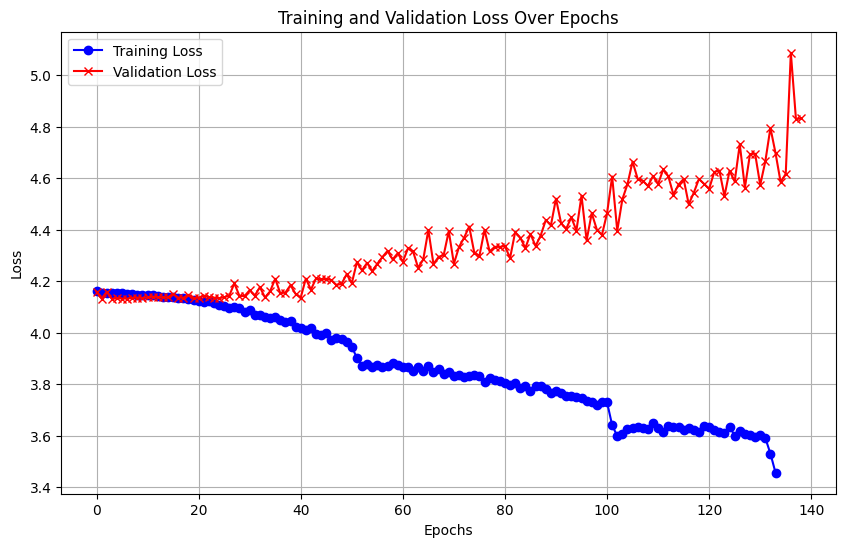

In [66]:
train_loss_history,val_loss_history = loss_tracking_callback.train_loss_history, loss_tracking_callback.val_loss_history

# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_loss_history, label='Training Loss', color='blue', linestyle='-', marker='o')

# Plot validation loss
plt.plot(val_loss_history, label='Validation Loss', color='red', linestyle='-', marker='x')

# Adding title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adding a legend
plt.legend()

# Show grid
plt.grid(True)


## Downstream task: retrieval

Try your hand at various downstream tasks: compute embeddings over images, see if they are able to identify similar images/light curves better than the base model. See if the model has learned useful joint representations by trying retrieval across modalities (image to light curve and vice versa).

Looks like we can pick up similar light curves. Can you improve the model -- the light curves encoder (see last notebook), the image model, or the loss function?

In [58]:
def cosine_similarity(a, b, temperature=1):
    a_norm = a / a.norm(dim=-1, keepdim=True)
    b_norm = b / b.norm(dim=-1, keepdim=True)
    
    logits = a_norm @ b_norm.T * temperature
    return logits.squeeze()

In [67]:
embs_curves_train,embs_images_train = get_embs(clip_model,train_loader_no_aug)
embs_curves_val,embs_images_val = get_embs(clip_model,val_loader_no_aug)

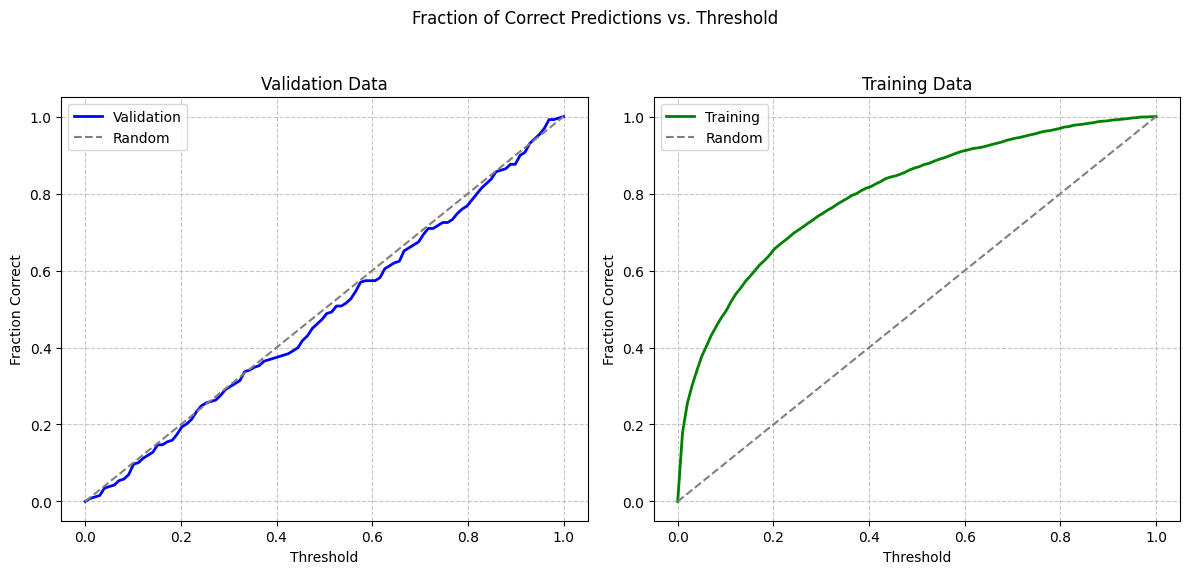

In [68]:

import matplotlib.pyplot as plt

def plot_ROC_curves(embs_curves_train: torch.Tensor, embs_images_train: torch.Tensor, embs_curves_val: torch.Tensor, embs_images_val: torch.Tensor) -> None:
    """
    Plots ROC-like curves for training and validation datasets based on embeddings.

    Args:
    embs_curves_train (torch.Tensor): Embeddings for light curves in the training set.
    embs_images_train (torch.Tensor): Embeddings for images in the training set.
    embs_curves_val (torch.Tensor): Embeddings for light curves in the validation set.
    embs_images_val (torch.Tensor): Embeddings for images in the validation set.
    """
    thresholds, fraction_correct_train = get_ROC_data(embs_curves_train, embs_images_train)
    thresholds, fraction_correct_val = get_ROC_data(embs_curves_val, embs_images_val)
    
    # Set overall figure size and title
    plt.figure(figsize=(12, 6))
    plt.suptitle('Fraction of Correct Predictions vs. Threshold')

    # Plot for validation data
    plt.subplot(1, 2, 1)
    plt.plot(thresholds, fraction_correct_val, color='blue', lw=2, label='Validation')
    plt.plot(thresholds, thresholds, linestyle='--', color='gray', label='Random')
    plt.title('Validation Data')
    plt.xlabel('Threshold')
    plt.ylabel('Fraction Correct')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot for training data
    plt.subplot(1, 2, 2)
    plt.plot(thresholds, fraction_correct_train, color='green', lw=2, label='Training')
    plt.plot(thresholds, thresholds, linestyle='--', color='gray', label='Random')
    plt.title('Training Data')
    plt.xlabel('Threshold')
    plt.ylabel('Fraction Correct')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_ROC_curves(embs_curves_train,embs_images_train,embs_curves_val,embs_images_val)

### Downstream tasks: detecting interesting samples from a big survey sample

Since we have access to a huge collection of (bulk) light curves (see `xx_ssl_lightcurve_encoder.ipynb`), we can also try to find interesting samples from this super noisy dataset based on the learned multimodal representations, by asking which light curves from the bulk samples are similar to given "interesting" light curves from the BTS sample.

### Downstream tasks: fine-tuning and classification

Since we also have access to properties like redshift, we can train a regression head on top of the learned representations, to then classify the bulk light curves.

In [ ]:
df_properties = pd.read_csv("../data/ZTFBTS/ZTFBTS_TransientTable.csv")
df_properties.head()

In particular, try to just do linear regression (add a single `nn.Linear` layer on top) after freezing the learned encoder weights from either image and/or light curve representations to see if you can do inference on e.g. the redshift.